In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import matplotlib.patches as patches

## 数据集读取与标签可视化

In [2]:
# 文件名
f_img = '.\\Plate_dataset\\AC\\train\\jpeg\\2.jpg'
f_xml = '.\\Plate_dataset\\AC\\train\\xml\\2.xml'

In [3]:
# 读取图像
img = cv2.imread(f_img)
# 读取xml
anno = ET.ElementTree(file=f_xml)
# 读取车牌字符label
label = anno.find('object').find('platetext').text

# bounding box
bound = ('xmin', 'ymin', 'xmax', 'ymax')
bbox = anno.find('object').find('bndbox')
bbox = [int(bbox.find(i).text) for i in bound]

3733JJ


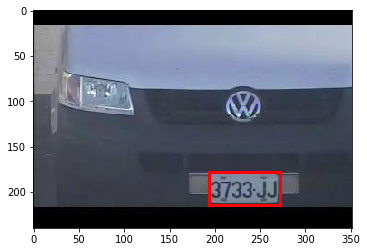

In [4]:
fig = plt.figure()
ax = plt.gca()
# 显示图像
plt.imshow(img[:,:,::-1])
# Create a Rectangle patch
rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1],linewidth=3,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

print(label)

### 经验图像处理方法
1. gt框大小的统计分析
2. 直接边缘检测

In [5]:
train_img_dir = "./Plate_dataset/AC/train/jpeg/"
train_xml_dir = "./Plate_dataset/AC/train/xml/"

train_imgs = os.listdir(train_img_dir)
train_xmls = os.listdir(train_xml_dir)

bound = ('xmin', 'ymin', 'xmax', 'ymax')
bboxes = pd.DataFrame(columns=bound)

for i, xml in enumerate(train_xmls):
    f_xml = os.path.join(train_xml_dir, xml)
    anno = ET.ElementTree(file=f_xml)
    bbox = anno.find('object').find('bndbox')

    bboxes.loc[i] = {i: int(bbox.find(i).text) for i in bound}
bboxes

,xmin,ymin,xmax,ymax
0,231,172,310,209
1,200,154,275,187
2,16,125,89,156
3,17,73,86,105
4,1,125,70,159
...,...,...,...,...
576,17,171,95,206
577,6,188,83,219
578,10,175,86,209
579,244,179,322,213


In [6]:
height = bboxes['width'] = bboxes['xmax'] - bboxes['xmin']
width = bboxes['height'] = bboxes['ymax'] - bboxes['ymin']
h_w = bboxes['h/w'] = bboxes['height'] / bboxes['width']

print('plate\tMAX\tMIN\tMEAN')
print('height\t{}\t{}\t{:.4f}'.format(height.max(), height.min(), height.mean()))
print('width\t{}\t{}\t{:.4f}'.format(width.max(), width.min(), width.mean()))
print('h/w\t{:.4f}\t{:.4f}\t{:.4f}'.format(h_w.max(), h_w.min(), h_w.mean()))

plate	MAX	MIN	MEAN
height	83	23	69.6403
width	37	15	31.0929
h/w	0.6522	0.3286	0.4480


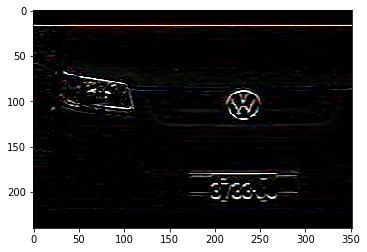

In [7]:
plt.imshow(cv2.Sobel(img, -1, 0, 1))

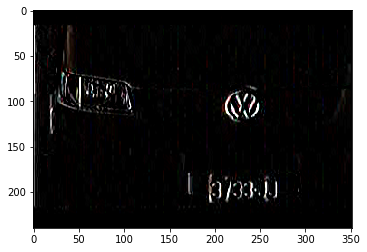

In [8]:
plt.imshow(cv2.Sobel(img, -1, 1, 0))

In [9]:
def stretch(img):
    max = float(img.max())
    min = float(img.min())

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i, j] = (255 / (max - min)) * img[i, j] - (255 * min) / (max - min)

    return img


def dobinaryzation(img):
    max = float(img.max())
    min = float(img.min())

    x = max - ((max - min) / 2)
    ret, thresholdimg = cv2.threshold(img, x, 255, cv2.THRESH_BINARY)

    return thresholdimg


def find_retangle(contour):
    y, x = [], []

    for p in contour:
        y.append(p[0][0])
        x.append(p[0][1])

    return [min(y), min(x), max(y), max(x)]


def locate_license(img, orgimg):
    img, contours, hierachy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # 找到最大的三个区域
    blocks = []
    for c in contours:
        # 找出轮廓的左上和右下点，计算出其面积和长宽比
        r = find_retangle(c)
        a = (r[2] - r[0]) * (r[3] - r[1])
        s = (r[2] - r[0]) / (r[3] - r[1])

        blocks.append([r, a, s])

    # 选出面积最大的3个区域
    blocks = sorted(blocks, key=lambda b: b[2])[-3:]

    # 使用颜色识别判断出最像车牌的区域
    maxweight, maxinedx = 0, -1

    for i in range(len(blocks)):
        b = orgimg[blocks[i][0][1]:blocks[i][0][3], blocks[i][0][0]:blocks[i][0][2]]
        # RGB 转HSV
        hsv = cv2.cvtColor(b, cv2.COLOR_BGR2HSV)

        # 蓝色车牌范围
        lower = np.array([100, 50, 50])
        upper = np.array([140, 255, 255])

        # 根据阈值构建掩膜
        mask = cv2.inRange(hsv, lower, upper)

        # 统计权值
        w1 = 0
        for m in mask:
            w1 += m / 255

        w2 = 0
        for w in w1:
            w2 += w

        # 选出最大权值的区域
        if w2 > maxweight:
            maxindex = i
            maxweight = w2

    return blocks[maxindex][0]


def find_license(img):
    '''预处理'''
    # 压缩图像
    a = 400 * img.shape[0] / img.shape[1]
    a = int(a)
    img = cv2.resize(img, (400, a))
    cv2.imshow('img',img)
    cv2.waitKey()

    # RGB转灰色
    grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imshow('grayimg', grayimg)
    cv2.waitKey()

    # 灰度拉伸
    stretchedimg = stretch(grayimg)
    cv2.imshow('stretchedimg', stretchedimg)
    cv2.waitKey()

    # 进行开运算，用来去除噪声
    r = 16
    h = w = r * 2 + 1
    kernel = np.zeros((h, w), dtype=np.uint8)
    cv2.circle(kernel, (r, r), r, 1, -1)
    openingimg = cv2.morphologyEx(stretchedimg, cv2.MORPH_OPEN, kernel)
    cv2.imshow('openingimg', openingimg)
    cv2.waitKey()

    strtimg = cv2.absdiff(stretchedimg, openingimg)
    cv2.imshow('strtimg', strtimg)
    cv2.waitKey()

    # 图像二值化
    binaryimg = dobinaryzation(strtimg)
    cv2.imshow('binaryimg', binaryimg)
    cv2.waitKey()

    # Canny算子进行边缘检测
    cannyimg = cv2.Canny(binaryimg, binaryimg.shape[0], binaryimg.shape[1])
    cv2.imshow('cannyimg', cannyimg)
    cv2.waitKey()

    '''消除小区域，连通大区域'''
    # 进行闭运算
    kernel = np.ones((5, 19), np.uint8)
    closingimg = cv2.morphologyEx(cannyimg, cv2.MORPH_CLOSE, kernel)
    cv2.imshow('closingimg', closingimg)
    cv2.waitKey()

    # 进行开运算
    openingimg = cv2.morphologyEx(closingimg, cv2.MORPH_OPEN, kernel)
    cv2.imshow('openingimg', openingimg)
    cv2.waitKey()

    # 再次进行开运算
    kernel = np.ones((11, 5), np.uint8)
    openingimg = cv2.morphologyEx(openingimg, cv2.MORPH_OPEN, kernel)
    cv2.imshow('openingimg', openingimg)
    cv2.waitKey()

    # 消除小区域，定位车牌位置
    rect = locate_license(openingimg, img)
    return rect, img


orgimg = cv2.imread('.\\Plate_dataset\\AC\\train\\jpeg\\2.jpg')
rect, img = find_license(orgimg)

cv2.rectangle(img, (rect[0], rect[1]), (rect[2], rect[3]), (0, 255, 0), 2)
cv2.imshow('img', img)
cv2.waitKey()
cv2.destroyAllWindows()

## IOU计算

In [74]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    # box [xmin,ymin,xmax,ymax] 
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [75]:
bb_intersection_over_union([39, 63, 203, 112], [54, 66, 198, 114])

0.7980093676814989